In [1]:
import pandas as pd
import numpy as np

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing
# Import the ARIMA object
from statsmodels.tsa.arima.model import ARIMA

import random

In [2]:
# Get time series data:
timedata = pd.read_csv('../Ling/SteamCharts.csv',low_memory=False)

# Replace inf to NaN:
timedata = timedata.replace({np.inf:np.nan})
timedata = timedata.replace({'+Inf':np.nan})

In [3]:
len(timedata)

50100

In [4]:
# Get Perc_Gain and change data to float.
p_gain = timedata.loc[timedata['Perc_Gain']==1].reset_index(drop=True)

# Get Avg_Players.
avg_players = timedata.loc[timedata['Avg_Players']==1].reset_index(drop=True)
avg_pure = avg_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Get Peak_Players.
peak_players = timedata.loc[timedata['Peak_Players']==1].reset_index(drop=True)
peak_pure = peak_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

In [5]:
avg_players['max'] = avg_pure.max(axis=1)
avg_pure = avg_pure.drop(avg_players.loc[avg_players['max']<=0].index).drop(avg_players.loc[avg_players['max'].isna()==True].index)
avg_pure = avg_pure.reset_index(drop=True)

p_gain = p_gain.drop(avg_players.loc[avg_players['max']<=0].index).drop(avg_players.loc[avg_players['max'].isna()==True].index)
p_gain = p_gain.reset_index(drop=True)

p_gain_pure = p_gain.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

avg_players = avg_players.drop(avg_players.loc[avg_players['max']<=0].index).drop(avg_players.loc[avg_players['max'].isna()==True].index)
avg_players = avg_players.reset_index(drop=True)

# Add columns 
birth = [avg_pure.iloc[i].last_valid_index() for i in range(len(avg_pure))]
avg_players['birth']=birth
p_gain['birth']=birth

In [6]:
avg_players

,Name,App_id,Avg_Players,Gain,Perc_Gain,Peak_Players,Last 30 Days,April 2021,March 2021,February 2021,...,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012,max,birth
0,Counter-Strike: Global Offensive,730,1.0,0.0,0.0,0.0,694478.21,723346.52,740927.82,741013.24,...,17372.73,16164.22,14079.39,14134.1,10739.48,16000.75,15475.39,932.57,857604.22,July 2012
1,Dota 2,570,1.0,0.0,0.0,0.0,412538.77,413784.97,390412.76,404832.13,...,166972.97,147748.14,121924.42,101077.43,75965.44,61867.68,55768.61,52721.05,709178.26,July 2012
2,PLAYERUNKNOWN'S BATTLEGROUNDS,578080,1.0,0.0,0.0,0.0,181816.27,186110.65,193114.18,198957.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1584886.77,March 2017
3,Apex Legends,1172470,1.0,0.0,0.0,0.0,153386.92,124905.13,126121.06,120982.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126121.06,November 2020
4,Team Fortress 2,440,1.0,0.0,0.0,0.0,84791.61,88187.00,88703.56,101230.91,...,43210.75,44255.06,43623.98,42498.53,46978.7,50699.07,61561.37,45566.90,101230.91,July 2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9549,Azurael's Circle: Chapter 4,1060170,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20,April 2019
9550,Head Shot,485310,1.0,0.0,0.0,0.0,7.63,1.29,2.42,1.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.38,June 2016
9551,Othello Let's Go,1256490,1.0,0.0,0.0,0.0,0.28,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,September 2020
9552,The Westport Independent,352240,1.0,0.0,0.0,0.0,0.65,1.04,NaN,1.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.42,January 2016


Select games with the max of avg_players larger than or equal to 10 and are created between July 2012 and March 2021. There are 6471 such games.

In [7]:
avg1 = avg_players.loc[avg_players['max']>=10]
avg_pure1 = avg_pure.loc[avg_players['max']>=10]
p_gain1 = p_gain.loc[avg_players['max']>=10]
p_gain_pure1 = p_gain_pure.loc[avg_players['max']>=10]

avg1 = avg1.loc[avg_players['birth']!='July 2012']
avg1 = avg1.loc[avg_players['birth']!='March 2021']
avg1 = avg1.loc[avg_players['birth']!='April 2021'].reset_index(drop=True)

avg_pure1 = avg_pure1.loc[avg_players['birth']!='July 2012']
avg_pure1 = avg_pure1.loc[avg_players['birth']!='March 2021']
avg_pure1 = avg_pure1.loc[avg_players['birth']!='April 2021'].reset_index(drop=True)

p_gain1 = p_gain1.loc[p_gain['birth']!='July 2012']
p_gain1 = p_gain1.loc[p_gain['birth']!='March 2021']
p_gain1 = p_gain1.loc[p_gain['birth']!='April 2021'].reset_index(drop=True)

p_gain_pure1 = p_gain_pure1.loc[p_gain['birth']!='July 2012']
p_gain_pure1 = p_gain_pure1.loc[p_gain['birth']!='March 2021']
p_gain_pure1 = p_gain_pure1.loc[p_gain['birth']!='April 2021'].reset_index(drop=True)

Select games with no NaN data in between

In [8]:
incomplete_data = []
for i in range(len(avg1)):
    temp = avg_pure1.iloc[i]
    if np.isnan(temp[temp.first_valid_index():temp.last_valid_index()]).any():
        incomplete_data.append(i)
len(incomplete_data)

768

In [9]:
avg2 = avg1.drop(incomplete_data).reset_index(drop=True)
avg_pure2 = avg_pure1.drop(incomplete_data).reset_index(drop=True)

There are 768 over 6471 games with missing datas. Probably we can retain some of them if we have time to clean them up

In [10]:
avg_pure2

,April 2021,March 2021,February 2021,January 2021,December 2020,November 2020,October 2020,September 2020,August 2020,July 2020,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
0,186110.65,193114.18,198957.52,201247.19,189233.58,179520.26,162585.64,169093.71,192492.61,211700.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,124905.13,126121.06,120982.64,71766.74,64469.75,74957.26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,92647.80,89792.84,90647.64,101250.59,106914.27,76718.34,67193.03,68047.03,88398.36,83654.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,45629.18,53350.61,59394.05,44864.92,67000.69,99899.97,50809.40,53312.41,64263.74,68439.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,77590.25,86369.82,117742.27,142117.25,61171.65,55408.03,48550.80,46430.53,53287.65,58238.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5698,0.80,1.06,1.54,1.24,1.16,0.84,1.37,0.76,1.74,2.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5699,3.33,4.01,2.72,2.30,2.45,2.91,2.92,3.05,2.79,2.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5700,3.57,4.25,4.73,5.31,5.30,5.15,4.75,4.54,5.91,5.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5701,2.56,9.05,14.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Do exponential smoothing of p_gain for each game.

In [13]:
#Exponential smoothing:

def smooth_values(data, i_game, smoothing_level=.2):

    game_data = data.iloc[i_game]
    months = pd.to_datetime(game_data.index)
    game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
    temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()]
    
    # Fit exponential smoothing
    ses = SimpleExpSmoothing(temp.values)
    fit = ses.fit(smoothing_level=smoothing_level, optimized=False)
    return fit.fittedvalues

In [14]:
# getting the smoothed curve for each game

# Ordered in increasing time order.
smooth_timedata = []
broken_data=[]
for i in range(len(avg_pure2)):
    try:
        temp = smooth_values(avg_pure2,i)
        if np.isnan(temp).any():
            broken_data.append(i)
        else:
            smooth_timedata.append(temp)
    except:
        broken_data.append(i)

C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [15]:
len(broken_data)

2

Some datas create problems for exponential smoothing. There are only very few of those (2 out of 5703) and they are not played by a large group of players. Here we drop them.

In [16]:
#dropping games with broken data

avg_new = avg2.drop(index=broken_data).reset_index(drop=True)
avg_pure_new = avg_pure2.drop(index=broken_data).reset_index(drop=True)

In [17]:
avg_new.to_csv('Average_PLayers_Cleaned.csv')

In [18]:
pd.DataFrame(smooth_timedata).to_csv('Smooth_Average_Players_TimeData_Cleaned.csv')

Now we define the metric.

In [19]:
def rootmse(a, b):
    return np.sqrt(np.sum((a-b)**2))

def Gauss_weight(a, b, epsilon = 20):
    return np.exp(-epsilon*rootmse(a,b)**2)

To compare the shape of 2 curves, we want to compute the scalar that makes 2 curves close together by scaling only.

In [20]:
def mini_scaler(a,b):
    return np.sum(a*b)/np.sum(a**2)

With the weight function and minimizing scalar defined above, we define the weight average function that acts as our prediction.

In [201]:
def wt_avg(game, data, metric = Gauss_weight, epsilon = 20, threshold=0.4, horizon = 6):
    length = len(game)
    if np.max(np.abs(game))!=0:
        game_scaled = game / rootmse(game,0)
    else:
        game_scaled = game
    pred = np.zeros(length+horizon)
    close_index = np.zeros((len(data),2))
    j=0
    for i in range(len(data)):
        temp = data[i]
        if len(temp)>=length+horizon:
            if np.max(np.abs(temp[:length]))!=0:
                temp_scaled = temp * mini_scaler(temp[:length],game_scaled)
            else: temp_scaled = temp
            weight=metric(game_scaled,temp_scaled[:length], epsilon = epsilon)
            if weight >= threshold:
                pred = pred + weight * temp_scaled[:length+horizon]
                close_index[j]=[i,weight]
                j=j+1
    if np.max(np.abs(pred)) !=0:
        pred = pred * mini_scaler(pred[:length],game)
    close_index = close_index[:j]
    close_index = close_index[np.argsort(close_index[:, 1])][::-1]
    return pred, close_index

Let's try an example:

In [116]:
subdata = smooth_timedata[0:800]
game = smooth_timedata[1000][:12]
[pred,close_index] = wt_avg(game,subdata, epsilon = 20, horizon = 6, threshold = 0.4)

len(close_index)

257

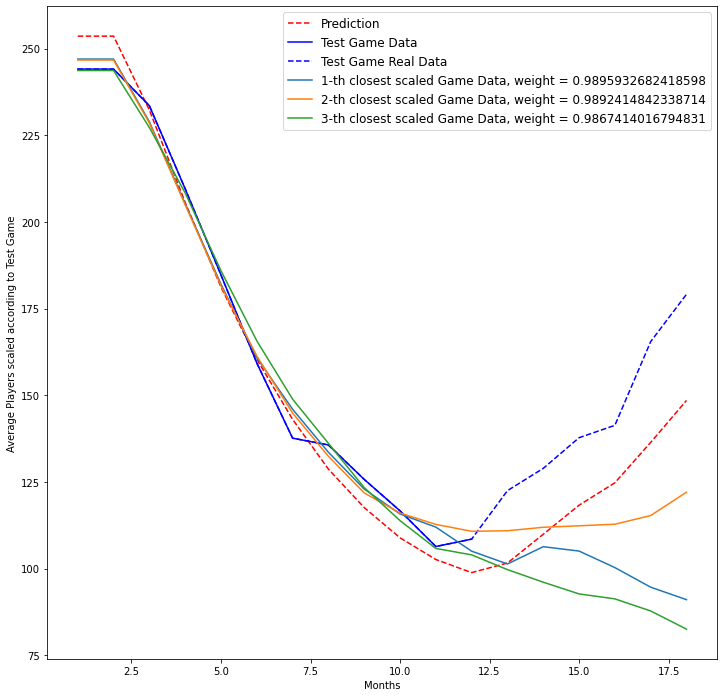

In [117]:
plt.figure(figsize=(12,12))
plt.plot(range(1,len(game)+7), pred, 'r--', label = 'Prediction')
plt.plot(range(1,len(game)+1), game, 'b', label = 'Test Game Data')
plt.plot(range(1,len(game)+7), smooth_timedata[1000][:18], 'b--', label = 'Test Game Real Data')

test_range = range(3)
for i in test_range:
    close_game = subdata[int(close_index[i][0])][:len(game)+6]
    scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
    plt.plot(range(1,len(game)+7), scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Months')
plt.ylabel('Average Players scaled according to Test Game')
plt.show()

Let's try the game Among Us

In [118]:
subdata = smooth_timedata[100:2000]
game = smooth_timedata[avg_new.loc[avg_new['Name']=='Among Us'].index.values[0]][0:12]
[pred,close_index] = wt_avg(game,subdata, epsilon = 20, horizon = 6, threshold = 0.2)

len(close_index)

29

In [119]:
pred

array([  1.45173357,   1.45173357,   1.88205898,   2.40775871,
         3.03669246,   3.67535745,   4.84791579,   8.27348986,
        19.04734676,  56.55992734,  86.61976985, 100.84612973,
       105.58905516, 110.22721181, 114.27312986, 128.98716338,
       139.57384675, 147.91506293])

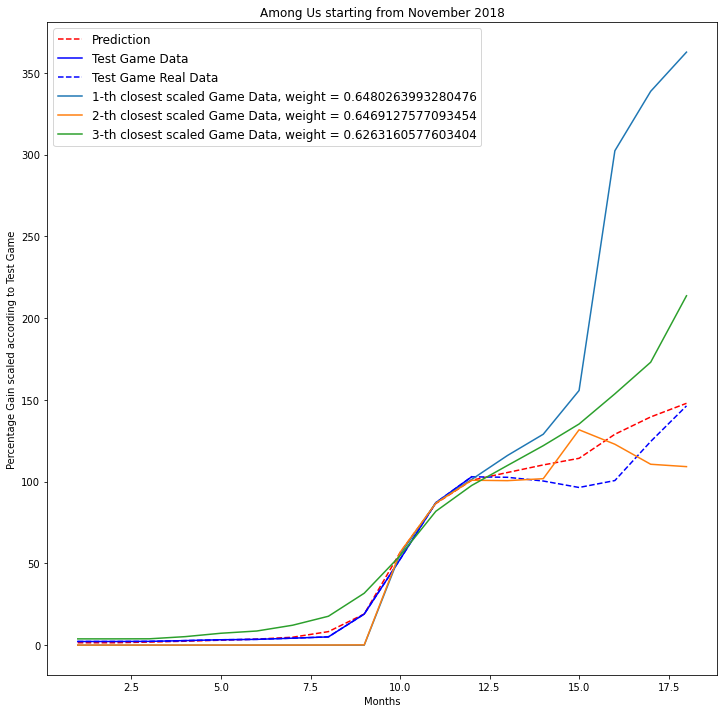

In [120]:
game_index = avg_new.loc[avg_new['Name']=='Among Us'].index.values[0]

plt.figure(figsize=(12,12))
plt.plot(range(1,len(game)+7), pred, 'r--', label = 'Prediction')
plt.plot(range(1,len(game)+1), game, 'b', label = 'Test Game Data')
plt.plot(range(1,len(game)+7), smooth_timedata[game_index][:18], 'b--', label = 'Test Game Real Data')

test_range = range(3)
for i in test_range:
    close_game = subdata[int(close_index[i][0])][:len(game)+6]
    scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
    plt.plot(range(1,len(game)+7), scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Months')
plt.ylabel('Percentage Gain scaled according to Test Game')
plt.title(str(avg_new['Name'][game_index]) + ' starting from ' + str(avg_new['birth'][game_index]))
plt.show()

Let's focus our attention on predicting 6 horizon given 12 month datas of games we want to predict.

Different horizon or given data may change the accuracy or the best smoothing/metric for prediction.

To check accuracy, we only consider games having 18 months or more data.

In [121]:
#dropping datas with less than 18 months
X = smooth_timedata.copy()
for i in range(len(smooth_timedata)):
    j=len(smooth_timedata)-i-1
    if len(smooth_timedata[j])<18:
        del X[j]

In [122]:
len(X)

4289

Now we do train test split and perform the real data analysis. Due to the nature of the above approach, there is no target.

In [192]:
test_index = random.sample(range(len(X)),int(len(X)/4))
X_test = [X[index] for index in test_index]

train_index = list(range(len(X)))
for i in test_index:
    train_index.remove(i)
X_train = [X[index] for index in train_index]

In [193]:
len(X_train)

3217

Now we define the error measurement we want to minimise. Since we used l2 norm, i.e. rootmse, in the above calculation, we also use that here.

In order to calculate average 'percentage error' over the test set, we normalize the error by the l2 norm of the test data. Equivalently, we are normalizing the l2 norm of the predicted values and the test data before computing the error.

Here percentage error refers to the error relative to the l2 norm of test data

In [125]:
def Get_error(train, test, threshold = 0.4, epsilon = 20):
    error = 0
    for i in range(len(test)):
        [pred, close_index] = wt_avg(test[i][:12],train, threshold = threshold, epsilon = epsilon, horizon = 6)
        error = error + rootmse(pred[12:],test[i][12:18]) / np.sum(test[i][12:18]**2)
    error = error / len(test)
    return error

Trying with some examples:

In [159]:
subdata = X_train
real_game = X_test[13][:18]
game = real_game[:12]
[pred,close_index] = wt_avg(game,subdata, horizon = 6, epsilon = 20, threshold = 0.4)

In [160]:
len(close_index)

26

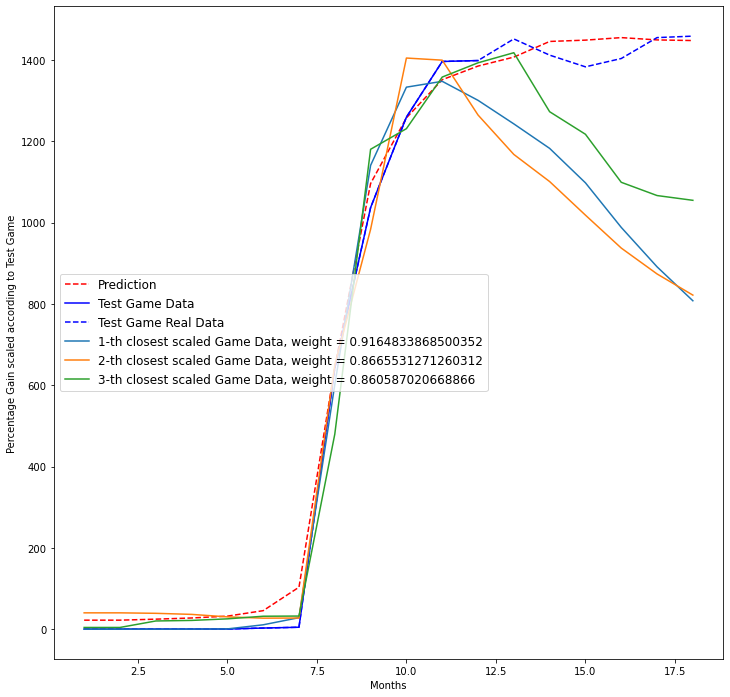

In [161]:
plt.figure(figsize=(12,12))
plt.plot(range(1,len(game)+7), pred, 'r--', label = 'Prediction')
plt.plot(range(1,len(game)+1), game, 'b', label = 'Test Game Data')
plt.plot(range(1,len(game)+7), real_game, 'b--', label = 'Test Game Real Data')

test_range = range(3)
for i in test_range:
    close_game = subdata[int(close_index[i][0])][:len(game)+6]
    scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
    plt.plot(range(1,len(game)+7), scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Months')
plt.ylabel('Percentage Gain scaled according to Test Game')
plt.show()

Cross Validation to get the best parameters for the model.

In [173]:
# CV 5 fold split
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5, shuffle = True, random_state = 440)

In [194]:
len(X_train)

3217

In [198]:
for train_index, test_index in kfold.split(X_train):
    X_train_train = [X_train[index] for index in train_index]
    print(len(X_train))

2573
2573
2573
2573
2573


In [209]:
def Get_best_eps_thres(data):
    error = 5
    best_eps = 50
    best_thres = 0.5
    for epsilon in np.arange(5,25,5):
        for threshold in np.arange(0.1,0.55,0.1):
            temp_error = 0
            for train_index, test_index in kfold.split(data):
                X_train = [data[index] for index in train_index]
                X_test = [data[index] for index in test_index]
                temp_error = temp_error + Get_error(X_train, X_test, threshold = threshold, epsilon = epsilon)
        if temp_error < error:
                error = temp_error
                best_eps = epsilon
                best_thres = threshold
    error = error / 5
    return best_eps, best_thres, error

In [210]:
[best_eps, best_thres, error] = Get_best_eps_thres(X_train)

In [215]:
print('optimal epsilon = ' + str(best_eps) + ', optimal threshold = ' + str(best_thres) + ', percentage error = ' + str(error) + '.')

optimal epsilon = 15, optimal threshold = 0.5, percentage error = 0.07206175793273498.


In [26]:
def ARIMA_plot(data, i_game,pred_k=14, smoothing_level=.2,order=(1,0,1),scale= 1,title='ARIMA prediction'):

    game_data = data.drop(columns=['Name']).iloc[i_game]
    months = pd.to_datetime(game_data.index)
    game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
    game.Month[-pred_k:]
        
# Use ARIMA smoothing to predict the last k months
    test = game[-pred_k:]
    train = game.drop(test.index)
    arima = ARIMA(train['Data'], order = order)
    fit = arima.fit()

    plt.figure(figsize=(8,6))
    plt.plot(game.Month[:len(game.Month)-pred_k],train['Data'],'b',label = "Training Data")
    plt.plot(game.Month[:len(game.Month)-pred_k],fit.fittedvalues/scale,'r-',label = "Fitted Values")
    
    plt.plot(game.Month[-pred_k:],test['Data']/scale,'b--',label = "Test Data")
    plt.plot(game.Month[-pred_k:],fit.forecast(len(test))/scale,'r--',label = "Forecast")

    plt.legend(fontsize=14)
    plt.xlabel("Month", fontsize=16)
    plt.ylabel('Number of '+title, fontsize=16)
    plt.title(str(data.Name.iloc[i_game]))
    plt.show()

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


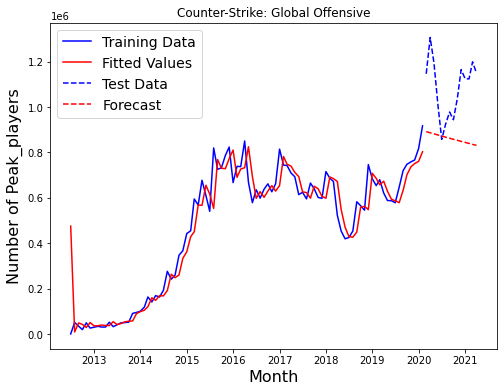

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


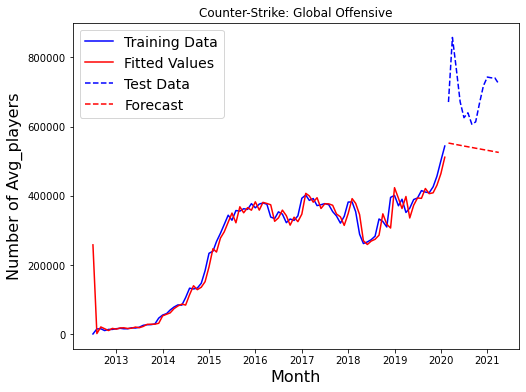

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


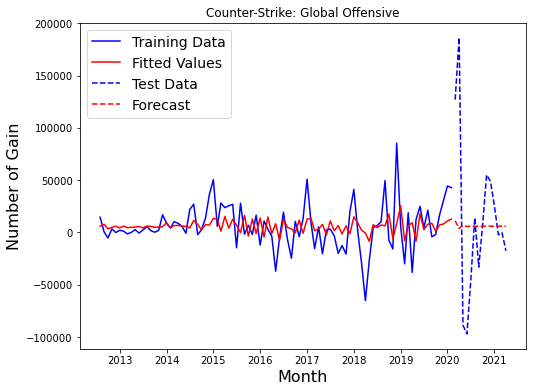

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


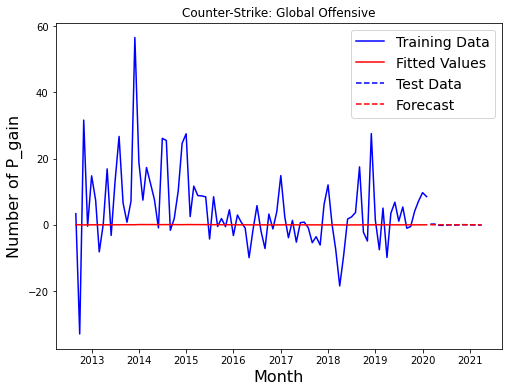

In [27]:
order = (1,0,1)
i = 0

ARIMA_plot(peak_plot, i_game=i,order=order,title='Peak_players')
ARIMA_plot(avg_plot,i_game=i,order=order,title='Avg_players')
ARIMA_plot(gain_plot,pred_k=14, i_game=i,order=order,title='Gain')
ARIMA_plot(p_gain_plot,pred_k=14, i_game=i,order=order,scale=100,title='P_gain')